In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/andreanavarrete/workspace/columbia/courses/capstone/BlackLivesMatter/dsi-capstone-f19-group-1-51b3e5d95350.json'


In [2]:
import json
import matplotlib.pyplot as plt
import re
import numpy as np
import swifter

from google.cloud import bigquery

%load_ext google.cloud.bigquery
plt.style.use('fivethirtyeight')

In [3]:
keys = ['Pronoun', 'Ppron',
        'I', 'We', 'You', 'SheHe', 'They',
        'Anger', 'Sad',
        'Sexual', 
        'Negate',
        'Social', 'Family', 'Friend',
        'Percept', 
        'Swear',
        'Drives', 'Affiliation',
        'Achieve', 'Power', 'Reward', 
        'Risk', 'Death']

In [4]:
bigquery_client = bigquery.Client(project='dsi-capstone-f19-group-1')

In [5]:
%%bigquery tweets
SELECT
    id, created_at, cleaned_text_length, is_retweet,
    CASE  WHEN (Pronoun_length > 0)  then 1 else 0 end as pronoun_dummy,
    CASE  WHEN (Ppron_length > 0)  then 1 else 0 end as ppron_dummy,
    CASE  WHEN (I_length > 0)  then 1 else 0 end as i_dummy,
    CASE  WHEN (We_length > 0)  then 1 else 0 end as we_dummy,
    CASE  WHEN (You_length > 0)  then 1 else 0 end as you_dummy,
    CASE  WHEN (SheHe_length > 0)  then 1 else 0 end as shehe_dummy,
    CASE  WHEN (They_length > 0)  then 1 else 0 end as they_dummy,
    CASE  WHEN (Anger_length > 0)  then 1 else 0 end as anger_dummy, 
    CASE  WHEN (Sad_length > 0)  then 1 else 0 end as sad_dummy,
    CASE  WHEN (Sexual_length > 0)  then 1 else 0 end as sexual_dummy,
    CASE  WHEN (Negate_length > 0)  then 1 else 0 end as negate_dummy,
    CASE  WHEN (Social_length > 0)  then 1 else 0 end as social_dummy,
    CASE  WHEN (Family_length > 0)  then 1 else 0 end as family_dummy,
    CASE  WHEN (Friend_length > 0)  then 1 else 0 end as friend_dummy,
    CASE  WHEN (Percept_length > 0)  then 1 else 0 end as percept_dummy,
    CASE  WHEN (Swear_length > 0)  then 1 else 0 end as swear_dummy,
    CASE  WHEN (Drives_length > 0)  then 1 else 0 end as drives_dummy,
    CASE  WHEN (Affiliation_length > 0)  then 1 else 0 end as affiliation_dummy,
    CASE  WHEN (Achieve_length > 0)  then 1 else 0 end as achieve_dummy,
    CASE  WHEN (Power_length > 0)  then 1 else 0 end as power_dummy,
    CASE  WHEN (Risk_length > 0)  then 1 else 0 end as risk_dummy,
    CASE  WHEN (Death_length > 0)  then 1 else 0 end as death_dummy,
    CASE  WHEN (Reward_length > 0)  then 1 else 0 end as reward_dummy
FROM features.lwic
LIMIT 100000
;

In [6]:
tweets.head()

,id,created_at,cleaned_text_length,is_retweet,pronoun_dummy,ppron_dummy,i_dummy,we_dummy,you_dummy,shehe_dummy,...,friend_dummy,percept_dummy,swear_dummy,drives_dummy,affiliation_dummy,achieve_dummy,power_dummy,risk_dummy,death_dummy,reward_dummy
0,498056511118376960,2014-08-09 10:41:40+00:00,23,False,1,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,1
1,498294036961046500,2014-08-10 02:25:30+00:00,21,True,1,1,0,1,0,1,...,0,0,0,1,1,0,1,0,0,1
2,500325983811928060,2014-08-15 16:59:44+00:00,26,False,1,1,1,1,0,0,...,0,1,0,1,1,0,1,0,0,1
3,500338583476002800,2014-08-15 17:49:48+00:00,21,True,1,1,0,1,0,1,...,0,1,0,1,1,0,1,0,1,0
4,501498606080520200,2014-08-18 22:39:19+00:00,23,False,1,1,0,1,0,0,...,1,1,0,1,1,0,1,0,0,0


In [7]:
tweets['date'] = tweets['created_at'].apply(lambda x: x.date().day)

In [8]:
## Functions
def pivot_table_metrics(keys):
    d  = {'{}_dummy'.format(x) : [np.mean] for x in keys }
    df_pivot = tweets.pivot_table(index='date',  aggfunc=d).reset_index()
    df_pivot.columns = ['_'.join(list(x)) for x in df_pivot.columns]
    return df_pivot

def plot_timeline(df, key):
    fig, ax = plt.subplots(figsize=(8,4))


    # Visualize the result
    mean_d = plt.plot(df['date_'], 
                  df['{}_dummy_mean'.format(key)], '-', 
                  label='Mean Ratio')
    # std
    #min_= list((df['{}_dummy_mean'.format(key)] -  df['{}_dummy_nanstd'.format(key)]).values)
    #max_ = list((df['{}_dummy_mean'.format(key)] +  df['{}_dummy_nanstd'.format(key)]).values)
    
    #std_d = plt.fill_between(df['date_'], 
    #             max(list(np.zeros(df.shape[0])), 
    #                 min_), 
    #             max_,
    #             color='gray', alpha=0.2,
    #            label='Std Ratio')
    plt.title('{} Ratio Timeline'.format(key.capitalize()), size=20)
    plt.ylabel('Number of days', size=15)
    plt.xlabel('Date of creation', size=15)
    #plt.ylim(0,max(max_))
    #plt.legend()
    
def plot_means(df, keys):
    fig, ax = plt.subplots(figsize=(15,6))
    for key in keys:
        ax.plot(df['date_'], 
                  df['{}_dummy_mean'.format(key)], '-', 
                  label='{} Mean Ratio'.format(key.capitalize()))
    plt.legend()

In [9]:
tweets['created_at'].max()

Timestamp('2014-09-01 04:51:26+0000', tz='UTC')

## Emotions

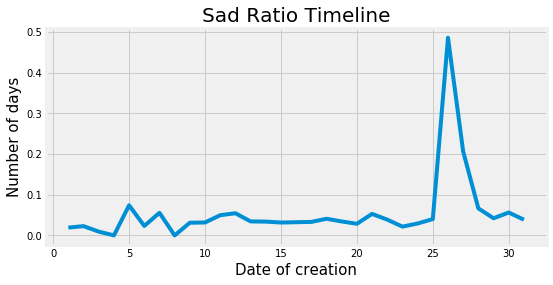

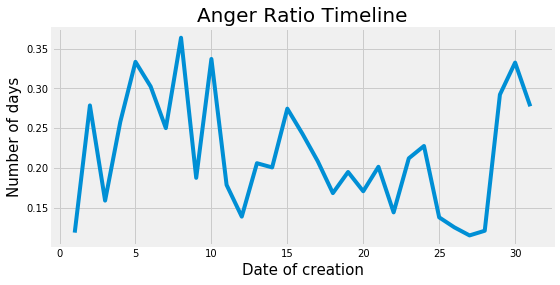

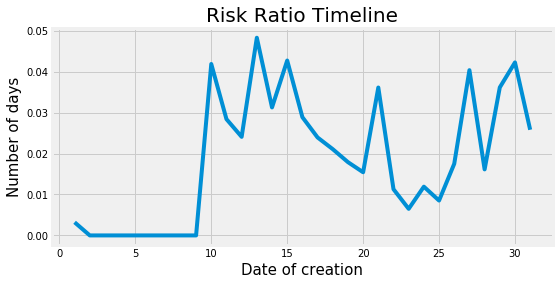

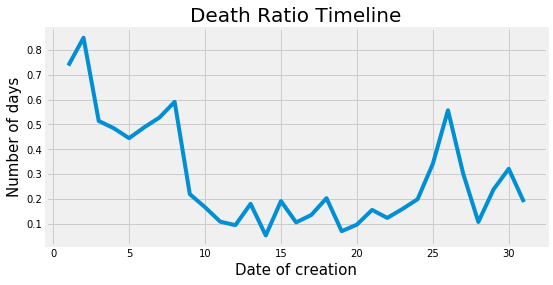

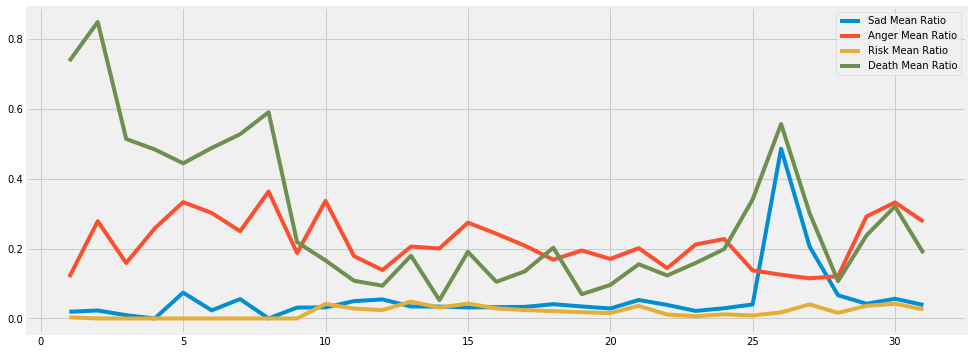

In [10]:
emotion_keys = ['sad', 'anger', 'risk', 'death']

df_emotions = pivot_table_metrics(emotion_keys)

for key in emotion_keys:
    plot_timeline(df_emotions, key)
    
plot_means(df_emotions, emotion_keys)

## Pronouns

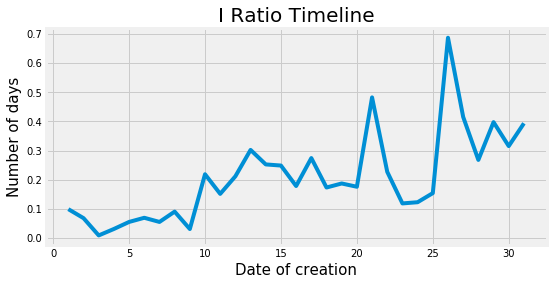

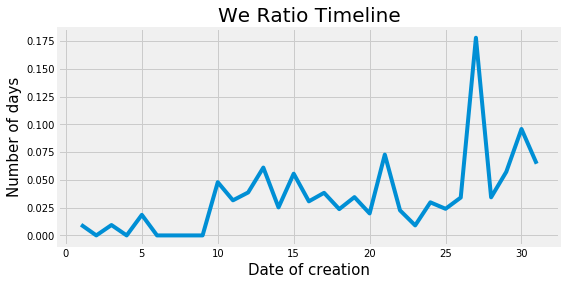

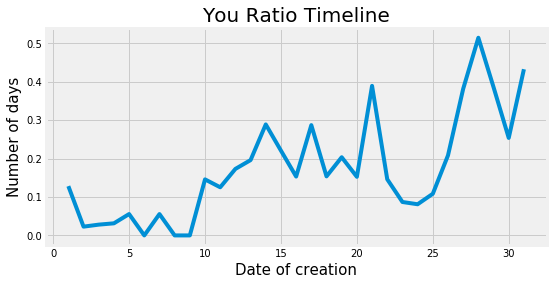

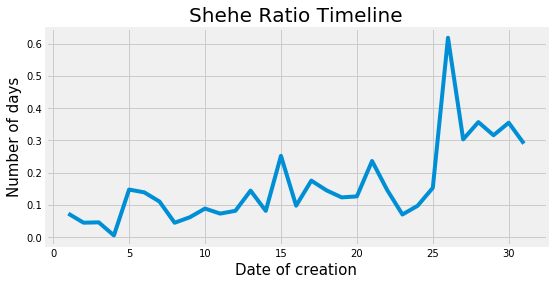

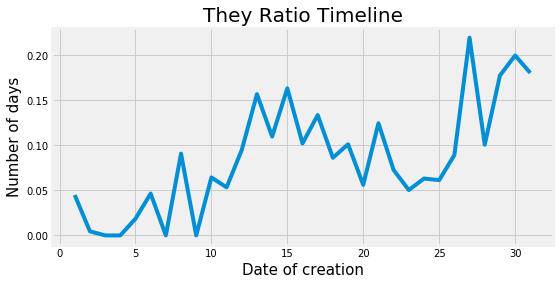

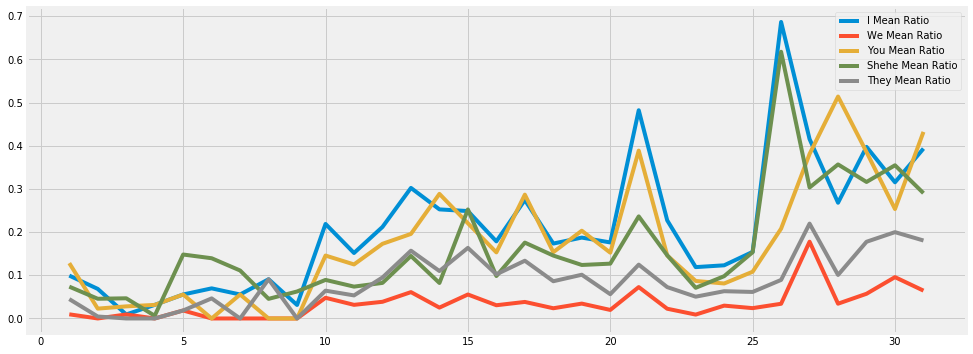

In [11]:
## PRonouns
pronoun_keys = ['i', 'we', 'you', 'shehe', 'they']

df_pronouns = pivot_table_metrics(pronoun_keys)

for key in pronoun_keys:
    plot_timeline(df_pronouns, key)
    
plot_means(df_pronouns, pronoun_keys)

## Social

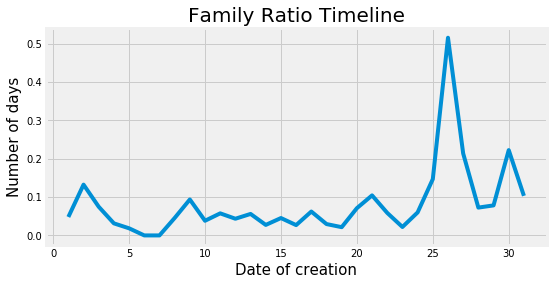

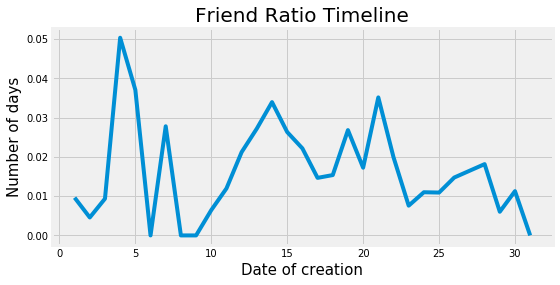

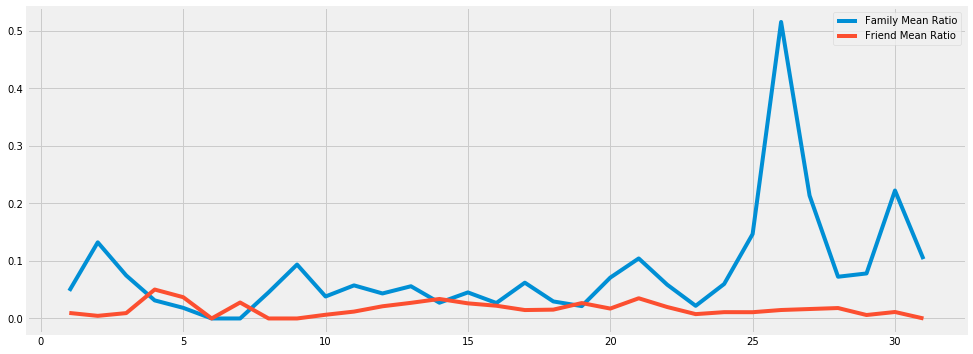

In [12]:
## PRonouns
social_keys = ['family', 'friend']

df_social = pivot_table_metrics(social_keys)

for key in social_keys:
    plot_timeline(df_social, key)
    
plot_means(df_social, social_keys)

## Other

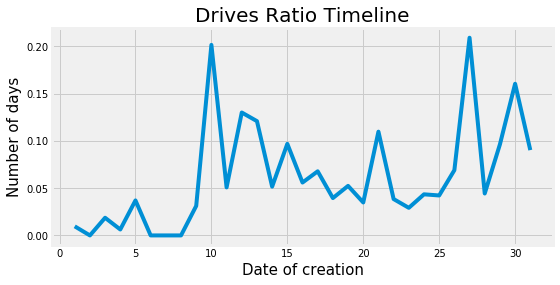

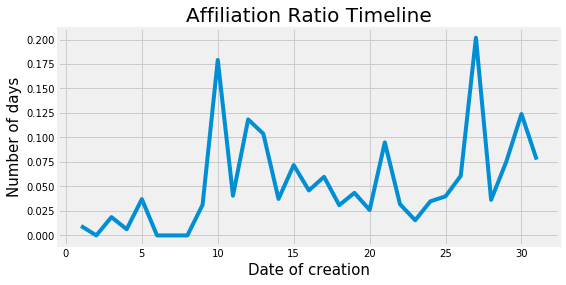

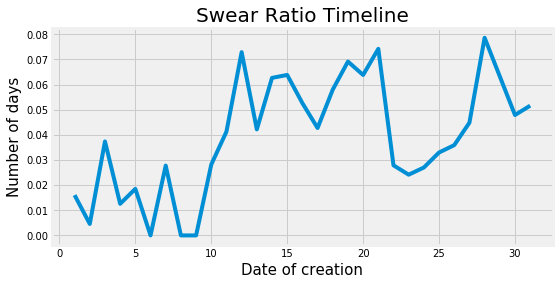

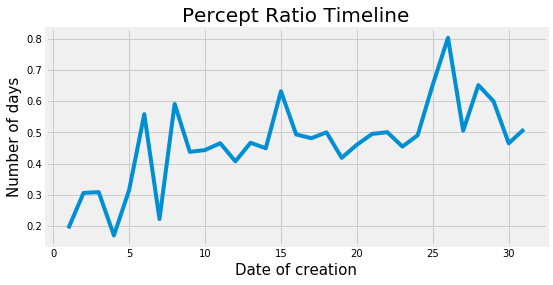

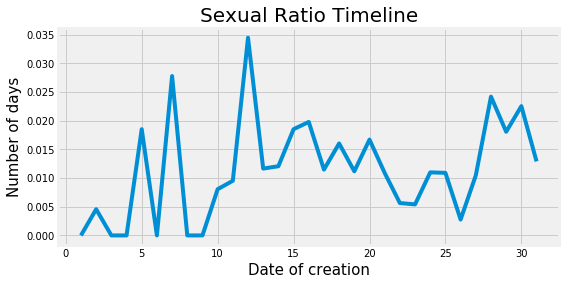

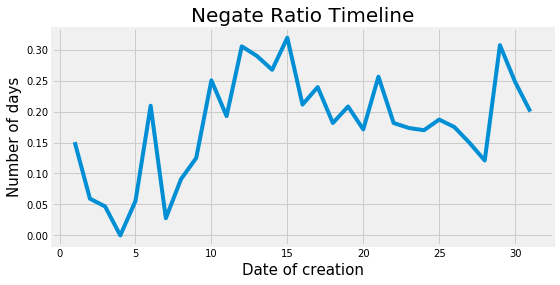

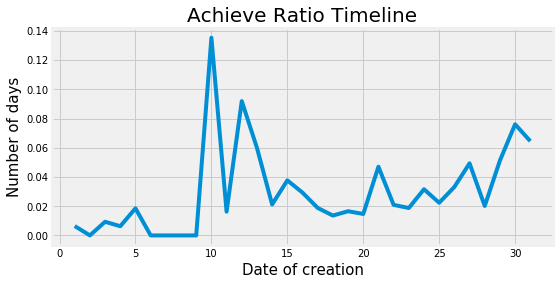

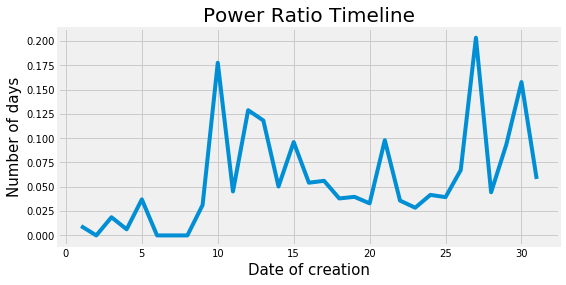

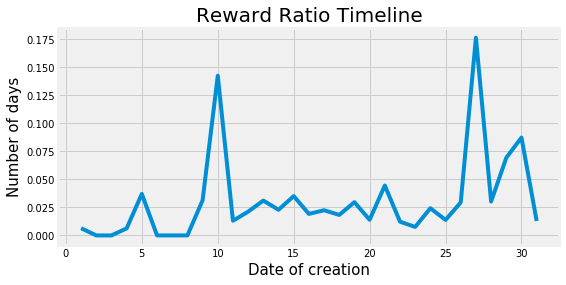

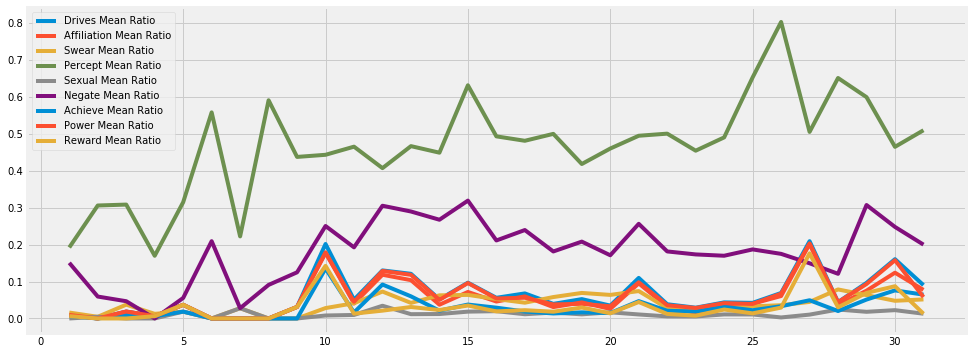

In [13]:
other_keys = ['drives', 'affiliation',
              'swear', 'percept',
              'sexual', 'negate',
        'achieve', 'power', 'reward']

df_other = pivot_table_metrics(other_keys)

for key in other_keys:
    plot_timeline(df_other, key)
    
plot_means(df_other, other_keys)